In [2]:
import transformers
from tqdm import tqdm
import torch
import torch.nn as nn

zh_tokenizer = transformers.AutoTokenizer.from_pretrained("hfl/chinese-xlnet-base")
en_tokenizer = transformers.AutoTokenizer.from_pretrained("xlnet-base-cased")

In [2]:
zh_tokenizer.convert_tokens_to_ids("<pad>"), en_tokenizer.convert_tokens_to_ids("<pad>")

(5, 5)

In [254]:
with open("./data/raw.en") as en, open("./data/tokens.en", "w") as en_tokens:
    data = en.readlines()
    for l in tqdm(range(len(data))):
        token_ids = en_tokenizer.encode(data[l],add_special_tokens=False)
        token_ids = [3] + token_ids + [4]
        #token_ids = [str(token_ids[i])+" " for i in range(len(token_ids))]
        tokens = en_tokenizer.convert_ids_to_tokens(token_ids)
        for token in tokens:
            en_tokens.write(token)
            en_tokens.write(" ")
        en_tokens.write("\n")

with open("./data/raw.zh") as zh, open("./data/tokens.zh", "w") as zh_tokens:
    data = zh.readlines()
    for l in tqdm(range(len(data))):
        token_ids = zh_tokenizer.encode(data[l],add_special_tokens=False)
        token_ids = [3] + token_ids + [4]
        #token_ids = [str(token_ids[i])+" " for i in range(len(token_ids))]
        tokens = zh_tokenizer.convert_ids_to_tokens(token_ids)
        for token in tokens:
            zh_tokens.write(token)
            zh_tokens.write(" ")
        zh_tokens.write("\n")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 320713/320713 [00:25<00:00, 12750.63it/s]


In [291]:
en_len = []
with open("./data/clean.en") as en:
    data = en.readlines()
    for l in range(len(data)):
        temp = data[l].split(" ")
        en_len.append(len(temp))
        
zh_len = []
with open("./data/clean.zh") as zh:
    data = zh.readlines()
    for l in range(len(data)):
        temp = data[l].split(" ")
        zh_len.append(len(temp))

In [297]:
max(en_len), max(zh_len)

(128, 128)

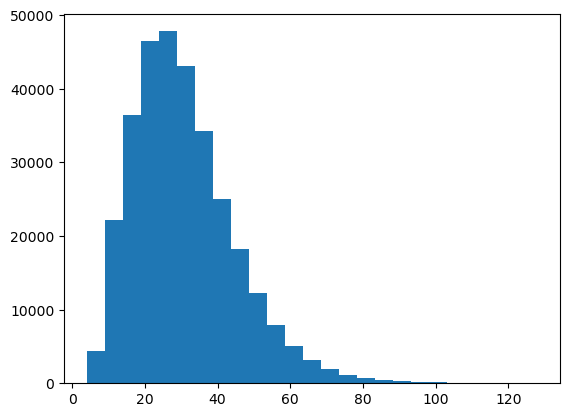

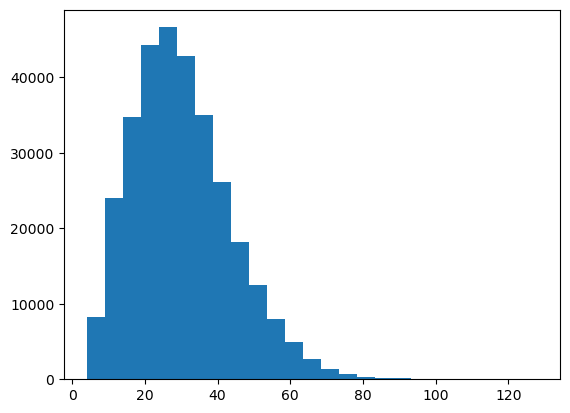

In [295]:
from matplotlib import pyplot

def drawHist(heights):
    pyplot.hist(heights, 25)
    pyplot.show()

drawHist(zh_len)
drawHist(en_len)

In [3]:
with open("./data/clean.en") as tokens, open("./data/ids.en", "w") as ids:
    data = tokens.readlines()
    for l in tqdm(range(len(data))):
        words = data[l][:-1].split(" ")
        idx = [en_tokenizer.convert_tokens_to_ids(words[i]) for i in range(len(words))]
        for token_id in idx:
            ids.write(str(token_id))
            ids.write(" ")
        ids.write("\n")

with open("./data/clean.zh") as tokens, open("./data/ids.zh", "w") as ids:
    data = tokens.readlines()
    for l in tqdm(range(len(data))):
        words = data[l][:-1].split(" ")
        idx = [zh_tokenizer.convert_tokens_to_ids(words[i]) for i in range(len(words))]
        for token_id in idx:
            ids.write(str(token_id))
            ids.write(" ")
        ids.write("\n")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 311054/311054 [00:06<00:00, 44680.69it/s]


In [4]:
class EntityDataset:
    def __init__(self, src, trg):
        self.src = src
        self.trg = trg
        self.MAX_LEN = 128
    
    def __len__(self):
        return len(self.src)
    
    def __getitem__(self, item):
        src = self.src[item]
        trg = self.trg[item]

        mask = [1] * len(src)

        src_padding_len = self.MAX_LEN - len(src)
        trg_padding_len = self.MAX_LEN - len(trg)

        src = src + ([5] * src_padding_len) 
        trg = trg + ([5] * trg_padding_len)

        return {
            "src": torch.tensor(src, dtype=torch.long),
            "trg": torch.tensor(trg, dtype=torch.long),
        }

In [19]:
def get_data_loader(en_path, zh_path):
    src_ids = []
    trg_ids = []

    with open(en_path) as src:
        data = src.readlines()
        for ids in tqdm(data):
            ids_list = ids.split(" ")[:-1]
            ids_list = [int(ids_list[i]) for i in range(len(ids_list))]
            src_ids.append(ids_list)

    with open(zh_path) as src:
        data = src.readlines()
        for ids in tqdm(data):
            ids_list = ids.split(" ")[:-1]
            ids_list = [int(ids_list[i]) for i in range(len(ids_list))]
            trg_ids.append(ids_list)
    return src_ids, trg_ids

In [ ]:
class Transformer(nn.Module):
    def __init__(self, 
                 embedding_size,
                 src_vocab_size,
                 trg_vocab_size,
                 src_pad_idx,
                 num_heads,
                 num_encoder_layers,
                 num_decoder_layers,
                 forward_expansion,
                 dropout,
                 max_len,
                 device,
                ):
        super(Transformer, self).__init__()
        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size)
        self.src_position_embedding = nn.Embedding(max_len, embedding_size)
        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len, embedding_size)
        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )
        
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx
    
    def make_src_mask(self, src):
        src_mask = src.transpose(0,1) == self.src_pad_idx
        return src_mask
    
    def forward(self, src, trg):
        src_seq_length, N = src.shape
        trg_seq_length, N = trg.shape
        
        src_positions = (
            torch.arange(0, src_seq_length).unsqueeze(1).expand(src_seq_length, N)
            .to(self.device)
        )
        
        trg_positions = (
            torch.arange(0, trg_seq_length).unsqueeze(1).expand(trg_seq_length, N)
            .to(self.device)
        )
        
        embed_src = self.dropout(
            (self.src_word_embedding(src) + self.src_position_embedding(src_positions))
        )
        
        embed_trg = self.dropout(
            (self.trg_word_embedding(trg) + self.trg_position_embedding(trg_positions))
        )
        
        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(self.device)
        
        out = self.transformer(
            embed_src,
            embed_trg,
            src_key_padding_mask = src_padding_mask,
            tgt_mask = trg_mask)
        
        out = self.fc_out(out)
        
        return out

In [21]:
train_en, train_zh = get_data_loader("./data/split/train.en", "./data/split/train.zh")
valid_en, valid_zh = get_data_loader("./data/split/valid.en", "./data/split/valid.zh")
test_en, test_zh = get_data_loader("./data/split/test.en", "./data/split/test.zh")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 15626/15626 [00:00<00:00, 189238.21it/s]


In [27]:
Batch_size = 64

train_dataset = EntityDataset(train_en, test_zh)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Batch_size)

valid_dataset = EntityDataset(valid_en, test_zh)
valid_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=Batch_size)

test_dataset = EntityDataset(test_en, test_zh)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=Batch_size)

In [5]:
train_losses, valid_losses, lr_s = [],[],[]
with open("/Users/lihongji/Desktop/neuralMT/adam_rec.txt") as adam_rec:
    data = adam_rec.readlines()
    for i in range(len(data)):
        #print(data[i].split(" | ")[0:2])
        train_loss = float(data[i].split(" | ")[0][12:-1])
        valid_loss = float(data[i].split(" | ")[1][12:-1])
        lr = float(data[i].split(" | ")[2][15:-1])
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        lr_s.append(lr)

with open("/Users/lihongji/Desktop/neuralMT/sgd_rec.txt") as sgd_rec:
    data = sgd_rec.readlines()
    for i in range(len(data)):
        #print(data[i].split(" | ")[0:2])
        train_loss = float(data[i].split(" | ")[0][12:-1])
        valid_loss = float(data[i].split(" | ")[1][12:-1])
        lr = float(data[i].split(" | ")[2][15:-1])
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        lr_s.append(lr)

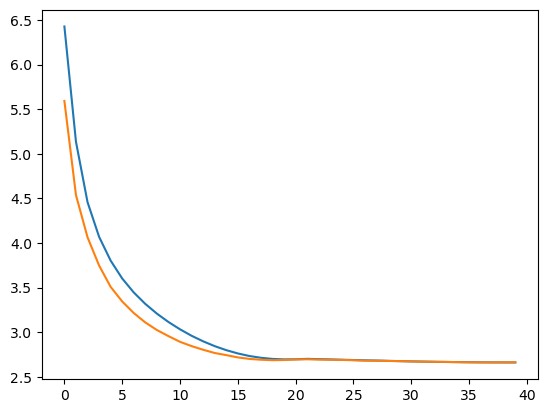

In [6]:
import matplotlib.pyplot as plt
x = [i for i in range(len(train_losses))]
plt.plot(x, train_losses)
plt.plot(x, valid_losses)
plt.show()

In [24]:
with open("/Users/lihongji/Desktop/neuralMT/data/split/test.zh") as zh, open("sgd_mt.txt", "w") as sgd_mt:
    data = zh.readlines()
    for i in range(len(data)):
        sentence = data[i].split(" ")[1:-2]
        sentence = [int(sentence[i]) for i in range(len(sentence))]
        output = zh_tokenizer.decode(sentence)
        sgd_mt.write(output)
        sgd_mt.write("\n")